In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Generate data

We now create a small artificial dataset from two sine functions with an additional  noise term. The signal is periodic and therefore relatively simple to learn, however, the high frequency component and noise allow for some complexity.

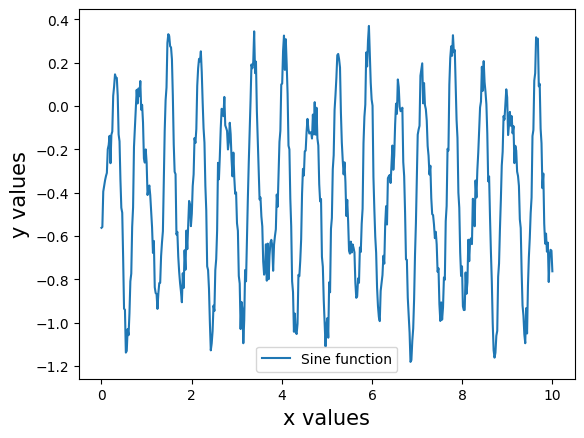

In [3]:
##
## generate data - a simple sine
##
def generate_data(x_min, x_max, n_datapoints=300,
                  f1 = 10, f2=20, offset1 = 0, offset2=0.2, noise=0.1):
  x = np.linspace(x_min, x_max, n_datapoints)
  y = 0.5*np.sin(f1*(x-offset1))+0.2*np.sin(f2*(x-offset2))+noise*np.random.rand(n_datapoints)-0.5
  return x,y

x_ticks,y = generate_data(x_min=0.0, x_max=10.0, n_datapoints=500,
                    f1=10, f2=17, offset1=0.1, offset2=0.3, noise=0.2)
plt.plot(x_ticks, y, label='Sine function')
plt.xlabel('x values', size=15)
plt.ylabel('y values', size=15)
plt.legend()
plt.show()



However, for forecastig, we are only interested in the $y$ values as this is
our timeseries. Therefore, from here we refer to the $y$-values only.

We would need  the $x$-values as indices for the $x$-axis in plotting - but they do not have any relevance for the timeseries forecasting as such.

Therefore, for now, we will just focus on the $y$ values.

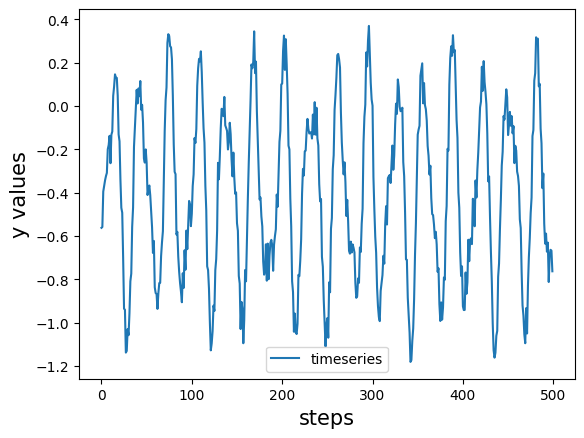

In [4]:
plt.plot(y, label='timeseries')
plt.xlabel('steps', size=15)
plt.ylabel('y values', size=15)
plt.legend()
plt.show()

In timeseries forecasting, we need to remember that the data-points are auto-correlated, i.e. previous data points (earlier in the series) carry the predictive power for the data points later in the series.

This means that we cannot use a fuction like [test_train_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from scikit-learn as these functions assume that
the data are i.i.d. distributed.

Instead, we take the first 80% of the timeseries as training data, and the remainint 20% as independent test data.
Note that, for the later use with PyTorch, we also convert the data from ```float``` to ```double``` (i.e. ```float32```).
We also need to bring the timeseries in the format expected later on (```np.reshape(.)```)

In [5]:
#convert from float to double
timeseries = y.astype('float32')
timeseries = np.reshape(timeseries, (len(timeseries),1))

# define the size of the size of the training data as 80%
train_size = round(len(timeseries) * 0.8)
test_size  = len(timeseries) - train_size

# the training data is then the timeseries from the beginning to 80%
train      = timeseries[:train_size]

# the test data starts at the index of the last element of the train series
# until the end of the array
test       = timeseries[train_size:]

# Generate training features

We now need to transform the data in to a sliding window of a fixed width.
One key feature of sequences is that the data points are auto-correlated which means that the sequence of the data points matters.
In "normal" supervised learning approaches we would shuffle the training data and reserve a fraction chosen at random as the test data.
In the case of time-series data, we cannot do this as the sequence of the data points is a key aspect of the structure of a time-series.

LSTM networks are a supervised training network where we predict a label (y_train) from a number of training data (x_data). In our case we take a part of the original training data by considering only a number n points at the time and then predict the next element that would follow immediately after this sequence of n points.
Then we shift the window by one time-step (or data point), consider the next window of n data-points and predict the one following the the new sequence
and repeat the process until we have processed the complete time-series.

Essentially, we give a sequence of time-series elements to the ML model and train the model on predicting the next point in the series

In [6]:
def create_features_target(data, seq_length):
  X, y = [], []

  for i in range(len(data) - seq_length):
    # a sequence of n points is taken as features for the trainnig
    x_value = data[i: i+seq_length]
    X.append(x_value)

    # the prediction target is then the shifted sequence,
    # i.e. including the next data-point (the one we are interested in)
    y_value = data[i+1 : i+seq_length+1]
    y.append(y_value)

  # convert to PyTorch data structures for later use
  return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [7]:
# as this is a relatively simple time-series, we only look at a short series
sequence_length = 4
X_train, y_train = create_features_target(train, sequence_length)
X_test, y_test = create_features_target(test, sequence_length)

In [8]:
# move to GPU, if available
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test  = X_test.to(device)
y_test  = y_test.to(device)

In [9]:
print(X_train.shape, y_train.shape)

torch.Size([396, 4, 1]) torch.Size([396, 4, 1])


# LSTM Model

We now need to create our LSTM model using the [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) from PyTorch.
In the following, we only need the output of the LSTM cell, but we do not need *h_n* and *c_n*. Therefore, we do not capture them (siginfied by the underscore).

We start with a simple network that has only one LSTM layer, followed
by a linear layer to convert the output of the LSTM cell back into a single,
real-valued number.

In [10]:
n_hidden_1 = 100

class Simple_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=n_hidden_1, num_layers=1, batch_first=True)
        self.linear = nn.Linear(n_hidden_1, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

# Network training

Now we need to train our (simple) network.
We start with the setups:

First we need to create an instance of our model, then choose an optimiser
(using the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimiser), and define a loss function.
Here, we use the mean squared error ([MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html))as a regression loss.

PyTorch offers a number of convencince functions for handling data.
Remember, up to this point, the training and test data are arrays of numbers. During trainign, we want to make use of batches, as well as not having to iterate over the data ourselves, including shuffling of the data between training epochs.
The main function that helps us here is [```DataLoader```](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), that, in turn, requires
PyTorch tensors which we can create using [```TensorDataset```](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset).

In [11]:
#
# setups
#

# instantiate model and move to GPU (if available)
model = Simple_Model().to(device)

# Optimizer
optimizer = optim.Adam(model.parameters())

# Loss function
loss_fn = nn.MSELoss()

# convenience function for handling training data
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
size = len(loader.dataset)

loss_values = []

#
# training loop
#
n_epochs = 200
for epoch in range(n_epochs):
    running_loss = 0.0
    # make sure we're in training mode
    model.train()

    #loop over all batches of training data
    for X_batch, y_batch in loader:

        #move to GPU, if available
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # prediction
        y_pred = model(X_batch)

        # loss function
        loss = loss_fn(y_pred, y_batch)
        loss_item = loss.item()
        running_loss += loss_item

        # network training step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_values.append(running_loss/size)

    # every n epochs, print the current value of the MSE for the
    # training and test data
    if epoch % 10 == 0:
      model.eval()
      with torch.no_grad():
        y_pred = model(X_train)
        train_mse = loss_fn(y_pred, y_train)

        y_pred = model(X_test)
        test_mse = loss_fn(y_pred, y_test)
        print('Epoch {}: train MSE {:.4f}, test MSE {:.4f}'.format(epoch, train_mse, test_mse))



Epoch 0: train MSE 0.1126, test MSE 0.1142
Epoch 10: train MSE 0.0128, test MSE 0.0135
Epoch 20: train MSE 0.0128, test MSE 0.0135
Epoch 30: train MSE 0.0119, test MSE 0.0125
Epoch 40: train MSE 0.0131, test MSE 0.0136
Epoch 50: train MSE 0.0115, test MSE 0.0120
Epoch 60: train MSE 0.0116, test MSE 0.0122
Epoch 70: train MSE 0.0115, test MSE 0.0120
Epoch 80: train MSE 0.0119, test MSE 0.0125
Epoch 90: train MSE 0.0115, test MSE 0.0121
Epoch 100: train MSE 0.0112, test MSE 0.0118
Epoch 110: train MSE 0.0113, test MSE 0.0118
Epoch 120: train MSE 0.0117, test MSE 0.0122
Epoch 130: train MSE 0.0112, test MSE 0.0118
Epoch 140: train MSE 0.0112, test MSE 0.0117
Epoch 150: train MSE 0.0112, test MSE 0.0117
Epoch 160: train MSE 0.0113, test MSE 0.0118
Epoch 170: train MSE 0.0112, test MSE 0.0117
Epoch 180: train MSE 0.0114, test MSE 0.0119
Epoch 190: train MSE 0.0113, test MSE 0.0119


# Model evaluation

In a first step, we look at the loss function.

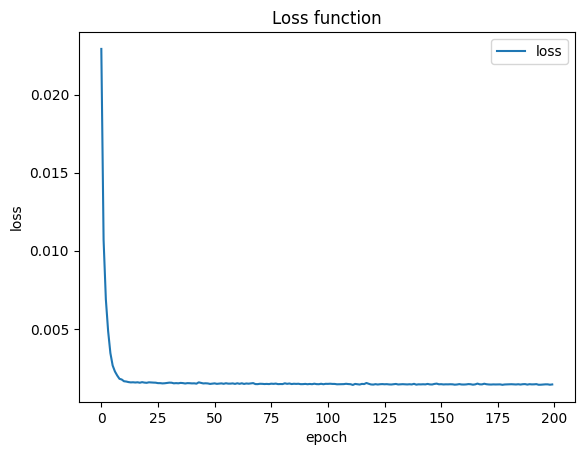

In [12]:
plt.title('Loss function')
plt.plot(loss_values, label='loss')
plt.xlabel('epoch', size = 10)
plt.ylabel('loss', size = 10)
plt.legend()
plt.show()

Now we look at how the model performs.
To do this, we make predictions on the training data (these should be good, as
the network has seen all this data during training), as well as on the independent test data. The performance on this latter part will show us, how well the network has learned the pattersn in the data.

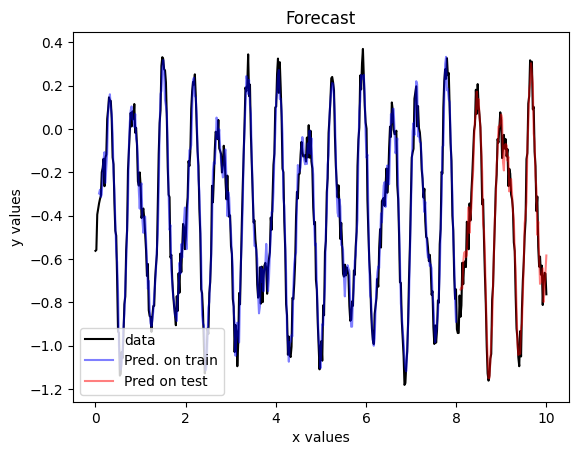

In [13]:
# first step: create some "dummy" arrays that will hold the
# the prediction on the training and test data.
train_plot = np.ones_like(timeseries) * np.nan
test_plot  = np.ones_like(timeseries) * np.nan

with torch.no_grad():
    #
    # predictions on the training data
    #
    y_pred_train = model(X_train)
    # take the last number in the sequence (the actual prediction we are
    # interested in). We also need to move it back to the CPU if
    # trainingn on GPU
    y_pred_train = y_pred_train[:, -1, :].cpu()
    train_plot[sequence_length:train_size] = y_pred_train


    #
    # predictions on the training data
    #
    y_pred_test = model(X_test)
    y_pred_test = y_pred_test[:, -1, :].cpu()
    test_plot[train_size+sequence_length:len(timeseries)] = y_pred_test

#
# now do the actual plot
#
plt.plot(x_ticks,timeseries, color='black', label='data')
plt.plot(x_ticks,train_plot, color='blue' , alpha=0.5, label='Pred. on train')
plt.plot(x_ticks,test_plot , color='red'  , alpha=0.5, label='Pred on test')
plt.legend()
plt.xlabel('x values' , size=10)
plt.ylabel('y values', size=10)
plt.title('Forecast')
plt.show()